In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class ReviewDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_len=128): # khởi tạo dataset
        self.df = pd.read_csv(csv_file) # đọc file csv
        self.df = self.df.dropna(subset=['clean_text', 'stars']) # xoá dòng null
        self.tokenizer = tokenizer
        self.max_len = max_len # độ dài tối đa của chuỗi đầu vào

    def __len__(self):
        return len(self.df) # trả về độ dài dataset

    def __getitem__(self, index):
        text = str(self.df.loc[index, 'clean_text']) # ép kiểu về str
        score = float(self.df.loc[index, 'stars']) # ép kiểu về float

        encoding = self.tokenizer.encode_plus(
            text, # chuỗi cần mã hoá
            add_special_tokens=True, # thêm token đặc biệt [CLS], [SEP] để Bert hiểu và bắt đầu phân loại
            max_length=self.max_len, # độ dài tối đa
            return_token_type_ids=False, # không trả về token type ids vì chỉ có một câu
            padding='max_length', # bổ sung dữ liệu nếu chuỗi ngắn hơn độ dài tối đa
            truncation=True, # cắt bớt dữ liệu nếu chuỗi dài hơn độ dài tối đa
            return_attention_mask=True, # trả về attention mask để Bert biết phần nào là dữ liệu thực, phần nào là padding
            return_tensors='pt', # trả về dưới dạng tensor của PyTorch
        )

        return { 
            'input_ids': encoding['input_ids'].flatten(), # flatten() để chuyển từ tensor 2D sang 1D
            'attention_mask': encoding['attention_mask'].flatten(), # flatten() để chuyển từ tensor 2D sang 1D
            'targets': torch.tensor(score, dtype=torch.float) # chuyển score về tensor float
        }

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') # sử dụng tokenizer của BERT

# Load Data 
test_dataset = ReviewDataset('test.csv', tokenizer)
val_dataset = ReviewDataset('val.csv', tokenizer) 

test_loader = DataLoader(test_dataset, batch_size=32)
val_loader = DataLoader(val_dataset, batch_size=32) 

c:\activities\DLProject\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import joblib # Để load file .pkl

class SMOTEDataset(Dataset):
    def __init__(self, features_path, labels_path):
        # Load dữ liệu và ép kiểu sang numpy array ngay lập tức
        data = joblib.load(features_path)
        
        # KIỂM TRA: Nếu lỡ load nhầm object Vectorizer thì báo lỗi luôn
        if not hasattr(data, '__getitem__') or 'Vectorizer' in str(type(data)):
            raise TypeError("File .pkl không chứa dữ liệu mảng. Có vẻ bạn load nhầm file Vectorizer!")
            
        self.features = np.array(data) 
        self.labels = pd.read_csv(labels_path)['stars'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        return {
            'input_ids': torch.tensor(self.features[item], dtype=torch.float32),
            'targets': torch.tensor(self.labels[item], dtype=torch.float32)
        }
        


# THAY ĐỔI: Sử dụng SMOTEDataset cho tập train
# Truyền đường dẫn file .pkl hoặc .npz và file .csv chứa nhãn vào
train_dataset_smote = SMOTEDataset(
    features_path='X_train_smote.pkl', 
    labels_path='y_train_smote.csv'
)

# Tạo train_loader từ dataset mới
# train_loader = DataLoader(train_dataset_smote, batch_size=32, shuffle=True)

# Giữ nguyên các loader khác


## Không dùng Concatenate

In [3]:
class BERTRegressor_head(nn.Module):
    def __init__(self, head_type='simple'):
        super(BERTRegressor_head, self).__init__() # Kế thừa từ nn.Module
        self.bert = BertModel.from_pretrained('bert-base-uncased') # Tải BERT base
        
        # Đóng băng BERT để kiểm tra sức mạnh nguyên bản
        for param in self.bert.parameters():
            param.requires_grad = False # Đóng băng trọng số gốc của BERT
            
        self.head_type = head_type
        
        #  ĐỊNH NGHĨA 4 LOẠI HEAD 
        if head_type == 'simple':
            self.regressor = nn.Linear(768, 1) # Loại 1: Đơn giản, chỉ một lớp Linear
            
        elif head_type == 'medium': # Loại 2: Thêm một lớp ẩn với ReLU
            self.regressor = nn.Sequential(
                nn.Linear(768, 256),
                nn.ReLU(), # Hàm kích hoạt ReLU giúp mô hình học các quan hệ phi tuyến tính
                nn.Linear(256, 1)
            )
            
        elif head_type == 'complex':
            self.regressor = nn.Sequential(
                nn.Linear(768, 512),
                nn.ReLU(),
                nn.Dropout(0.3), # Dropout để giảm overfitting
                nn.Linear(512, 128),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(128, 1)
            )
            
        elif head_type == 'bounded':
            self.regressor = nn.Sequential(
                nn.Linear(768, 256),
                nn.ReLU(),
                nn.Linear(256, 1),
                nn.Sigmoid() 
            )

    def forward(self, input_ids=None, attention_mask=None, smote_inputs=None):
    # --- BƯỚC 1: LẤY VECTOR ĐẶC TRƯNG (EMBEDDING) ---
        if smote_inputs is not None:
            # TRƯỜNG HỢP A: Training với vector SMOTE (Bỏ qua BERT)
            embedding = smote_inputs
        else:
            # TRƯỜNG HỢP B: Dữ liệu Text gốc (Chạy qua BERT)
            # Kiểm tra xem có input_ids không để tránh lỗi
            if input_ids is None or attention_mask is None:
                raise ValueError("Cần cung cấp input_ids và attention_mask nếu không dùng smote_inputs")
                
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            embedding = outputs.last_hidden_state[:, 0, :] # Lấy [CLS] token

        # --- BƯỚC 2: ĐƯA QUA ĐẦU DỰ ĐOÁN (HEAD) ---
        out = self.regressor(embedding)

        # --- BƯỚC 3: XỬ LÝ RIÊNG CHO BOUNDED HEAD ---
        # Nếu là bounded, output đang là Sigmoid [0, 1] -> cần scale lên [1, 5]
        if self.head_type == 'bounded':
            out = 1.0 + (out * 4.0)

        return out

In [4]:
import torch
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- 3. HÀM TRAIN & EVALUATE (ĐÃ SỬA CHO SMOTE) ---

def train_head_only(model, data_loader, criterion, optimizer, device):
    model.train() # đặt mô hình ở chế độ train
    losses = []
    
    for d in data_loader:
        # Lấy dữ liệu từ data loader
        # Lưu ý: Với SMOTEDataset, input_ids chứa vector float (768 chiều)
        # Với Dataset thường, input_ids chứa số nguyên long (token indices)
        inputs = d["input_ids"].to(device) 
        targets = d["targets"].to(device)
        
        # --- LOGIC TỰ ĐỘNG NHẬN DIỆN LOẠI DỮ LIỆU ---
        if inputs.dtype == torch.float32: 
            # TRƯỜNG HỢP 1: Dữ liệu SMOTE (Vector đặc trưng)
            # Gọi đường dẫn tắt (bypass BERT)
            outputs = model(smote_inputs=inputs)
            
        else:
            # TRƯỜNG HỢP 2: Dữ liệu thường (Token IDs)
            # Cần thêm attention_mask
            attention_mask = d["attention_mask"].to(device)
            # Gọi đường dẫn bình thường (qua BERT)
            outputs = model(input_ids=inputs, attention_mask=attention_mask)
        
        # ---------------------------------------------

        # Flatten outputs để khớp kích thước với targets
        loss = criterion(outputs.squeeze(), targets) 
        losses.append(loss.item()) # lưu giá trị loss

        optimizer.zero_grad() # xoá gradient cũ
        loss.backward()       # tính gradient mới
        optimizer.step()      # cập nhật trọng số
        
    return np.mean(losses)

def evaluate_model(model, data_loader, device):
    model.eval() # đặt mô hình ở chế độ đánh giá
    predictions = [] 
    real_values = []
    
    with torch.no_grad(): # tắt tính toán gradient
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            targets = d["targets"].to(device)
            
            # Hàm evaluate thường chạy trên tập Test/Val (dữ liệu thật)
            # nên luôn cần attention_mask và chạy qua BERT backbone
            if "attention_mask" in d:
                attention_mask = d["attention_mask"].to(device)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            else:
                # Fallback nếu lỡ ai đó evaluate trên tập SMOTE (hiếm khi dùng)
                outputs = model(smote_inputs=input_ids)
            
            # Xử lý output: squeeze để bỏ chiều batch=1 nếu có, tolist để chuyển về list Python
            # Logic: Nếu outputs là 1 số (scalar) -> bọc lại thành list
            batch_preds = outputs.squeeze().tolist()
            batch_targets = targets.tolist()
            
            # Đảm bảo luôn extend list (tránh lỗi nếu batch_size=1 trả về số thực thay vì list)
            if isinstance(batch_preds, float):
                predictions.append(batch_preds)
                real_values.append(batch_targets)
            else:
                predictions.extend(batch_preds)
                real_values.extend(batch_targets)
            
    # Tính toán metrics
    mse = mean_squared_error(real_values, predictions)
    mae = mean_absolute_error(real_values, predictions)
    
    # Tính thêm Accuracy (Làm tròn) để tham khảo
    acc = np.mean(np.round(predictions) == np.array(real_values))
    
    return mse, mae, real_values, predictions

In [3]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import json
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Early Stopping 
class EarlyStopping:
    def __init__(self, patience=3, verbose=False, path='checkpoint.pt'):
        self.patience = patience # số epoch chờ đợi trước khi dừng
        self.verbose = verbose # in thông báo debug
        self.counter = 0 # đếm số epoch không cải thiện
        self.best_score = None # Lưu điểm số tốt nhất tính từ lúc train đến hiện tại
        self.early_stop = False # cờ dừng sớm
        self.val_loss_min = np.inf # giá trị loss tối thiểu ban đầu
        self.path = path # đường dẫn lưu mô hình

    def __call__(self, val_loss, model):
        score = -val_loss # điểm số là âm của loss (giá trị càng cao càng tốt)
        if self.best_score is None:
            self.best_score = score # khởi tạo best_score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score: # không cải thiện
            self.counter += 1 # tăng bộ đếm
            if self.verbose: print(f'EarlyStopping: {self.counter}/{self.patience}')
            if self.counter >= self.patience: self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose: print(f'Loss giam. Luu model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


========== BẮT ĐẦU THỬ NGHIỆM VỚI SMOTE DATASET ==========

Dang train Head type: SIMPLE...


c:\activities\DLProject\venv\Lib\site-packages\torch\nn\modules\loss.py:626: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


  Epoch 1/20 | Train Loss (SMOTE): 0.7681 | Val Loss (Real): 0.8286
Loss giam. Luu model...
  Epoch 2/20 | Train Loss (SMOTE): 0.7144 | Val Loss (Real): 0.8508
EarlyStopping: 1/3
  Epoch 3/20 | Train Loss (SMOTE): 0.7080 | Val Loss (Real): 0.8634
EarlyStopping: 2/3
  Epoch 4/20 | Train Loss (SMOTE): 0.7048 | Val Loss (Real): 1.0806
EarlyStopping: 3/3
  ==> Dừng sớm (Early Stopping)!
  => Kết quả cuối cùng simple: MSE = 0.8472

Dang train Head type: MEDIUM...


c:\activities\DLProject\venv\Lib\site-packages\torch\nn\modules\loss.py:626: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


  Epoch 1/20 | Train Loss (SMOTE): 0.6835 | Val Loss (Real): 0.7526
Loss giam. Luu model...
  Epoch 2/20 | Train Loss (SMOTE): 0.6089 | Val Loss (Real): 0.7126
Loss giam. Luu model...
  Epoch 3/20 | Train Loss (SMOTE): 0.5824 | Val Loss (Real): 0.6861
Loss giam. Luu model...
  Epoch 4/20 | Train Loss (SMOTE): 0.5616 | Val Loss (Real): 0.6957
EarlyStopping: 1/3
  Epoch 5/20 | Train Loss (SMOTE): 0.5475 | Val Loss (Real): 0.8504
EarlyStopping: 2/3
  Epoch 6/20 | Train Loss (SMOTE): 0.5329 | Val Loss (Real): 0.6922
EarlyStopping: 3/3
  ==> Dừng sớm (Early Stopping)!
  => Kết quả cuối cùng medium: MSE = 0.7039

Dang train Head type: COMPLEX...


c:\activities\DLProject\venv\Lib\site-packages\torch\nn\modules\loss.py:626: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


  Epoch 1/20 | Train Loss (SMOTE): 0.8110 | Val Loss (Real): 0.7399
Loss giam. Luu model...
  Epoch 2/20 | Train Loss (SMOTE): 0.7020 | Val Loss (Real): 0.6987
Loss giam. Luu model...
  Epoch 3/20 | Train Loss (SMOTE): 0.6574 | Val Loss (Real): 1.0820
EarlyStopping: 1/3
  Epoch 4/20 | Train Loss (SMOTE): 0.6312 | Val Loss (Real): 0.7800
EarlyStopping: 2/3
  Epoch 5/20 | Train Loss (SMOTE): 0.6097 | Val Loss (Real): 0.8913
EarlyStopping: 3/3
  ==> Dừng sớm (Early Stopping)!
  => Kết quả cuối cùng complex: MSE = 0.7163

Dang train Head type: BOUNDED...


c:\activities\DLProject\venv\Lib\site-packages\torch\nn\modules\loss.py:626: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


  Epoch 1/20 | Train Loss (SMOTE): 0.6433 | Val Loss (Real): 0.6690
Loss giam. Luu model...
  Epoch 2/20 | Train Loss (SMOTE): 0.5739 | Val Loss (Real): 0.6438
Loss giam. Luu model...
  Epoch 3/20 | Train Loss (SMOTE): 0.5419 | Val Loss (Real): 0.6460
EarlyStopping: 1/3
  Epoch 4/20 | Train Loss (SMOTE): 0.5171 | Val Loss (Real): 0.6599
EarlyStopping: 2/3
  Epoch 5/20 | Train Loss (SMOTE): 0.4956 | Val Loss (Real): 0.6571
EarlyStopping: 3/3
  ==> Dừng sớm (Early Stopping)!
  => Kết quả cuối cùng bounded: MSE = 0.6636

--- ĐÃ LƯU XONG MODEL VÀ LỊCH SỬ TRAINING ---

========== KẾT QUẢ SO SÁNH (SMOTE) ==========
              MSE       MAE  Best_Epoch
simple   0.847155  0.729260         1.0
medium   0.703851  0.631431         3.0
complex  0.716345  0.650073         2.0
bounded  0.663604  0.589377         2.0


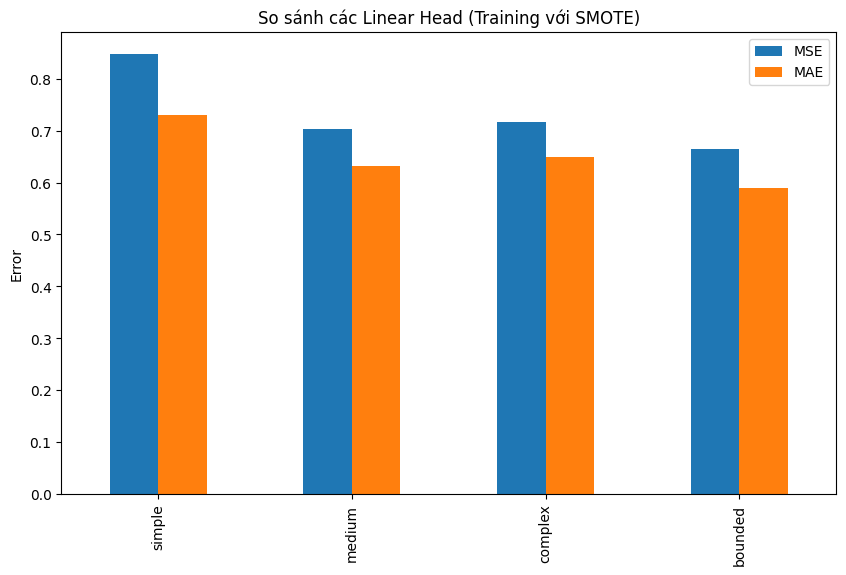

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt

# --- CONFIG ---
head_types = ['simple', 'medium', 'complex', 'bounded']
results = {}
EPOCHS = 20  
PATIENCE = 3 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"{'='*10} BẮT ĐẦU THỬ NGHIỆM VỚI SMOTE DATASET {'='*10}")
finetune_head_histories = {}

for head in head_types:
    print(f"\nDang train Head type: {head.upper()}...")
    
    model = BERTRegressor_head(head_type=head) 
    model = model.to(device)
    
    # 2. Setup Loss, Optimizer
    criterion = nn.MSELoss()
    # Chỉ optimize tham số của Regressor Head
    optimizer = torch.optim.Adam(model.regressor.parameters(), lr=0.001)
    
    # Setup Early Stopping
    save_path = f'{head}_best_model_Smote.pt' # <--- Sửa tên file lưu
    early_stopping = EarlyStopping(patience=PATIENCE, verbose=True, path=save_path)
    
    train_losses = []
    val_losses = []

    # 3. Training Loop
    for epoch in range(EPOCHS):
        model.train()
        batch_losses = []
        
        for d in train_loader: # train_loader này load từ file .pkl SMOTE
            
            smote_vectors = d["input_ids"].to(device) 
            targets = d["targets"].to(device)

            # GỌI MODEL VỚI THAM SỐ ĐẶC BIỆT
            outputs = model(smote_inputs=smote_vectors) 
            
            loss = criterion(outputs.squeeze(), targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        
        avg_train_loss = np.mean(batch_losses)
        train_losses.append(avg_train_loss)

        # --- VÒNG LẶP VALIDATION (DÙNG DỮ LIỆU GỐC) ---
        # Validation vẫn dùng text gốc nên phải chạy qua BERT Backbone
        model.eval()
        val_batch_losses = []
        with torch.no_grad():
            for d in val_loader: 
                input_ids = d["input_ids"].to(device)
                attention_mask = d["attention_mask"].to(device)
                targets = d["targets"].to(device)
                
                # GỌI MODEL THEO CÁCH BÌNH THƯỜNG (Có input_ids)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                
                loss = criterion(outputs.squeeze(), targets)
                val_batch_losses.append(loss.item())
        
        avg_val_loss = np.mean(val_batch_losses)
        val_losses.append(avg_val_loss)

        print(f"  Epoch {epoch+1}/{EPOCHS} | Train Loss (SMOTE): {avg_train_loss:.4f} | Val Loss (Real): {avg_val_loss:.4f}")

        # GỌI EARLY STOPPING 
        early_stopping(avg_val_loss, model)
        
        if early_stopping.early_stop:
            print("  ==> Dừng sớm (Early Stopping)!")
            break
            
    # 4. Load lại model tốt nhất
    model.load_state_dict(torch.load(save_path))
    
    # Đánh giá lại lần cuối trên Test Set (Dữ liệu thật)
    mse, mae, _, _ = evaluate_model(model, test_loader, device)
    results[head] = {'MSE': mse, 'MAE': mae, 'Best_Epoch': epoch - PATIENCE + 1}
    print(f"  => Kết quả cuối cùng {head}: MSE = {mse:.4f}")
    
    finetune_head_histories[head] = {'train_loss': train_losses, 'val_loss': val_losses}

# LƯU LỊCH SỬ VÀ KẾT QUẢ
with open('finetune_head_histories_smote.json', 'w') as f:
    json.dump(finetune_head_histories, f)

print("\n--- ĐÃ LƯU XONG MODEL VÀ LỊCH SỬ TRAINING ---")

# --- TỔNG KẾT ---
print(f"\n{'='*10} KẾT QUẢ SO SÁNH (SMOTE) {'='*10}")
results_df = pd.DataFrame(results).T
print(results_df)

# Vẽ biểu đồ
results_df[['MSE', 'MAE']].plot(kind='bar', figsize=(10, 6))
plt.title('So sánh các Linear Head (Training với SMOTE)')
plt.ylabel('Error')
plt.show()

Đã load lịch sử huấn luyện thành công!
========== ĐÁNH GIÁ VÀ VẼ BIỂU ĐỒ CHI TIẾT ==========
Đang đánh giá model: SIMPLE...
Đang đánh giá model: MEDIUM...
Đang đánh giá model: COMPLEX...
Đang đánh giá model: BOUNDED...


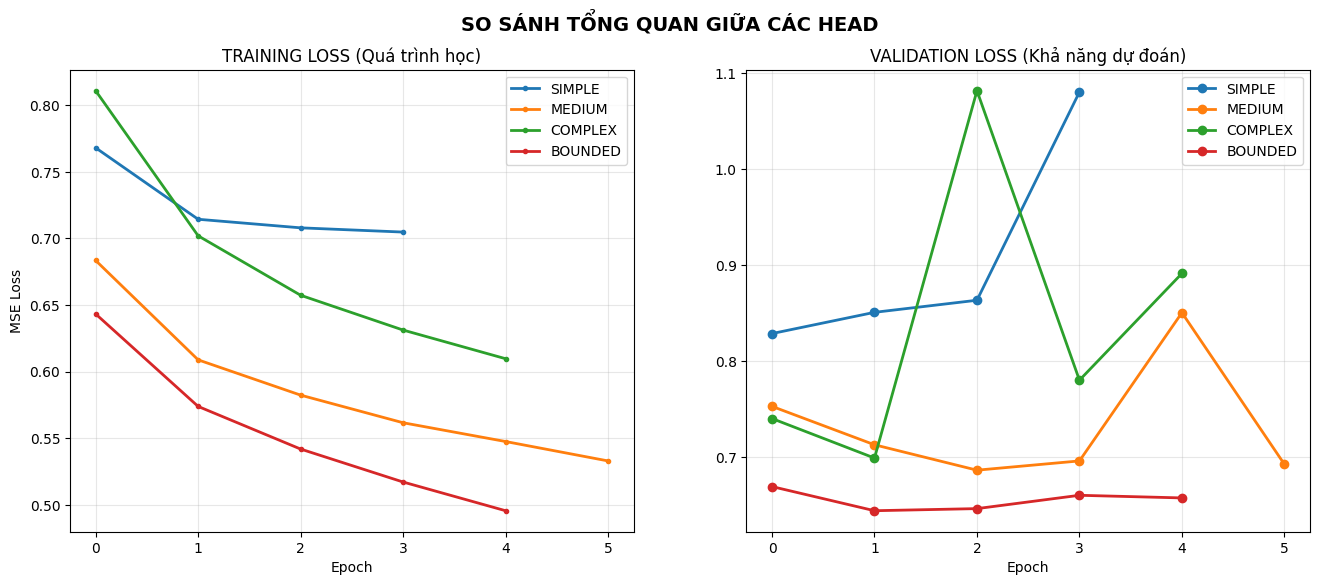


BẢNG XẾP HẠNG KẾT QUẢ (SMOTE TRAINING)
      Head       MSE       MAE        R2  Accuracy
3  BOUNDED  0.663604  0.589377  0.639658  0.547502
1   MEDIUM  0.703851  0.631431  0.617804  0.513684
2  COMPLEX  0.716345  0.650073  0.611019  0.488583
0   SIMPLE  0.847155  0.729260  0.539989  0.419414


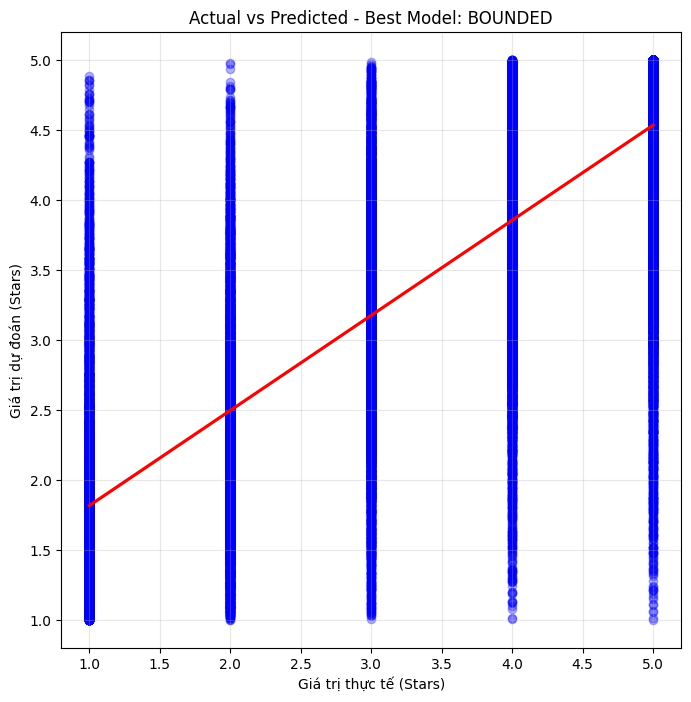

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pandas as pd
import torch
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- CẤU HÌNH ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
head_types = ['simple', 'medium', 'complex', 'bounded'] 

# 1. LOAD LỊCH SỬ TRAINING
try:
    with open('finetune_head_histories_smote.json', 'r') as f:
        histories = json.load(f)
    print("Đã load lịch sử huấn luyện thành công!")
except FileNotFoundError:
    print("CHƯA CÓ FILE LỊCH SỬ! Vui lòng chạy Cell Training trước.")
    histories = {} # Tạo dict rỗng để tránh lỗi vẽ biểu đồ sau này

final_results = []
all_preds = {}

# 2. ĐÁNH GIÁ MÔ HÌNH 
print(f"{'='*10} ĐÁNH GIÁ VÀ VẼ BIỂU ĐỒ CHI TIẾT {'='*10}")

for head in head_types:
    try:
        print(f"Đang đánh giá model: {head.upper()}...")
        
        model = BERTRegressor_head(head_type=head).to(device)

        
        # Load weight đã train
        model_path = f'{head}_best_model_Smote.pt' 
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()
        
        preds, actuals = [], []
        with torch.no_grad():
            for d in test_loader:
                input_ids = d['input_ids'].to(device)
                mask = d['attention_mask'].to(device)
                targets = d['targets'].to(device)
                
                outputs = model(input_ids=input_ids, attention_mask=mask)
                
                # Xử lý output
                p = outputs.squeeze().tolist()
                if isinstance(p, float):
                    preds.append(p)
                else:
                    preds.extend(p)
                actuals.extend(targets.tolist())
        
        mse = mean_squared_error(actuals, preds)
        mae = mean_absolute_error(actuals, preds)
        r2 = r2_score(actuals, preds)
        acc = np.mean(np.round(preds) == np.array(actuals))
        
        final_results.append({'Head': head.upper(), 'MSE': mse, 'MAE': mae, 'R2': r2, 'Accuracy': acc})
        all_preds[head] = {'actual': actuals, 'pred': preds}
        
    except Exception as e:
        print(f"Lỗi khi đánh giá model {head}: {e}")
        print("Gợi ý: Kiểm tra lại tên Class Model hoặc đường dẫn file .pt")

# 3. VẼ BIỂU ĐỒ LOSS
plt.rcParams.update({'font.size': 10})

if histories: # Chỉ vẽ nếu có lịch sử
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Vẽ Train Loss
    for head in head_types:
        if head in histories and len(histories[head]['train_loss']) > 0:
            axes[0].plot(histories[head]['train_loss'], label=f'{head.upper()}', marker='.', linewidth=2)
    axes[0].set_title('TRAINING LOSS (Quá trình học)')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('MSE Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Vẽ Val Loss
    for head in head_types:
        if head in histories and len(histories[head]['val_loss']) > 0:
            axes[1].plot(histories[head]['val_loss'], label=f'{head.upper()}', marker='o', linewidth=2)
    axes[1].set_title('VALIDATION LOSS (Khả năng dự đoán)')
    axes[1].set_xlabel('Epoch')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.suptitle("SO SÁNH TỔNG QUAN GIỮA CÁC HEAD", fontsize=14, fontweight='bold')
    plt.show()

# 4. HIỂN THỊ BẢNG KẾT QUẢ
if final_results:
    df_res = pd.DataFrame(final_results).sort_values(by='MSE')
    print("\n" + "="*40)
    print("BẢNG XẾP HẠNG KẾT QUẢ (SMOTE TRAINING)")
    print("="*40)
    print(df_res)
    
    # 5. VẼ BIỂU ĐỒ ACTUAL VS PREDICTED (Cho model tốt nhất)
    # Tìm model có MSE thấp nhất
    best_head_name = df_res.iloc[0]['Head'].lower()
    
    if best_head_name in all_preds:
        actuals = all_preds[best_head_name]['actual']
        preds = all_preds[best_head_name]['pred']

        plt.figure(figsize=(8, 8))
        sns.regplot(x=actuals, y=preds, scatter_kws={'alpha':0.3, 'color':'blue'}, line_kws={'color':'red'})
        plt.xlabel('Giá trị thực tế (Stars)')
        plt.ylabel('Giá trị dự đoán (Stars)')
        plt.title(f'Actual vs Predicted - Best Model: {best_head_name.upper()}')
        plt.grid(True, alpha=0.3)
        plt.show()
    else:
        print(f"Không tìm thấy dữ liệu dự đoán cho {best_head_name}")
else:
    print("Không có kết quả nào được ghi nhận. Vui lòng kiểm tra lỗi ở trên.")

## Áp dụng kỹ thuật Concatenate 4 layer cuối

Model

In [4]:
class BERTRegressor_head(nn.Module):
    def __init__(self, head_type='simple'):
        super(BERTRegressor_head, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
        
        # Đóng băng BERT
        for param in self.bert.parameters():
            param.requires_grad = False
            
        self.head_type = head_type
        input_dim = 768 * 4  # 3072
        
        # --- CẢI TIẾN: Thêm BatchNorm để ổn định dữ liệu đầu vào ---
        self.bn = nn.BatchNorm1d(input_dim)

        if head_type == 'simple':
            self.regressor = nn.Sequential(
                nn.Linear(input_dim, 1)
            )
            
        elif head_type == 'medium':
            self.regressor = nn.Sequential(
                nn.Linear(input_dim, 512),
                nn.BatchNorm1d(512), # Thêm BN
                nn.ReLU(),
                nn.Dropout(0.3),     # Thêm Dropout giảm overfitting
                nn.Linear(512, 1)
            )
            
        elif head_type == 'complex':
            self.regressor = nn.Sequential(
                nn.Linear(input_dim, 1024),
                nn.BatchNorm1d(1024),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(1024, 256),
                nn.BatchNorm1d(256),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, 1)
            )
            
        elif head_type == 'bounded':
            self.regressor = nn.Sequential(
                nn.Linear(input_dim, 256),
                nn.ReLU(),
                nn.Linear(256, 1),
                nn.Sigmoid() 
            )

    def forward(self, input_ids=None, attention_mask=None, smote_inputs=None):
        if smote_inputs is not None:
            # Training với SMOTE vectors
            embedding = smote_inputs
        else:
            # Inference/Validation với text gốc
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            hidden_states = outputs.hidden_states
            
            # --- SỬA LỖI: Đảo ngược thứ tự lấy layer để khớp với file tạo SMOTE ---
            # File tạo data dùng [-1, -2, -3, -4] -> Tức là [12, 11, 10, 9]
            # hidden_states có 13 phần tử (0->12). 
            # hidden_states[-1] là layer 12, hidden_states[-2] là layer 11...
            
            cls_embeddings = [hidden_states[i][:, 0, :] for i in [-1, -2, -3, -4]]
            
            # Nối lại: [Layer 12, Layer 11, Layer 10, Layer 9]
            embedding = torch.cat(cls_embeddings, dim=1)

        # --- Quan trọng: Đi qua BatchNorm trước khi vào Head ---
        # Lưu ý: BatchNorm cần input > 1 sample. Nếu batch_size=1 sẽ lỗi.
        if embedding.shape[0] > 1:
            embedding = self.bn(embedding)

        out = self.regressor(embedding)

        if self.head_type == 'bounded':
            out = 1.0 + (out * 4.0)

        return out

In [ ]:
import pandas as pd
import numpy as np
import torch
import joblib
from transformers import BertTokenizer, BertModel
from imblearn.over_sampling import SMOTE

MODEL_NAME = 'bert-base-uncased'
MAX_LEN = 128
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def recreate_smote_data_3072(csv_path):
    # 1. Load dữ liệu gốc
    df = pd.read_csv(csv_path)
    texts = df['clean_text'].tolist() 
    labels = df['stars'].values

    # 2. Khởi tạo BERT với cấu hình lấy Hidden States
    tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
    model = BertModel.from_pretrained(MODEL_NAME, output_hidden_states=True).to(DEVICE)
    model.eval()

    print(f"--- Bắt đầu trích xuất 3072 chiều từ {len(texts)} mẫu ---")
    features = []

    with torch.no_grad():
        for i in range(0, len(texts), BATCH_SIZE):
            batch_text = texts[i : i + BATCH_SIZE]
            
            # Tokenize
            inputs = tokenizer(batch_text, padding=True, truncation=True, 
                               max_length=MAX_LEN, return_tensors="pt").to(DEVICE)
            
            # Feed forward qua BERT
            outputs = model(**inputs)
            
            # Lấy 4 lớp cuối (index -1, -2, -3, -4) từ hidden_states
            # hidden_states[0] là embedding layer, [1-12] là encoder layers
            all_layers = outputs.hidden_states 
            cls_4_layers = [all_layers[i][:, 0, :] for i in [-1, -2, -3, -4]]
            
            # Concatenate thành vector 3072 chiều
            combined_vector = torch.cat(cls_4_layers, dim=1).cpu().numpy()
            features.append(combined_vector)
            
            if (i // BATCH_SIZE) % 10 == 0:
                print(f"Tiến độ: {i}/{len(texts)}...")

    X_3072 = np.vstack(features)
    
    # 3. Chạy SMOTE cân bằng dữ liệu
    print("\n--- Đang thực hiện SMOTE trên không gian 3072 chiều ---")
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_3072, labels)

    # 4. Lưu file mới
    joblib.dump(X_resampled, 'X_train_smote_3072.pkl')
    pd.DataFrame(y_resampled, columns=['stars']).to_csv('y_train_smote_3072.csv', index=False)
    
    print(f"\n✅ HOÀN TẤT!")
    print(f"Kích thước file mới: {X_resampled.shape}")
    print(f"Đã lưu: X_train_smote_3072.pkl và y_train_smote_3072.csv")

recreate_smote_data_3072('train.csv')

--- Bắt đầu trích xuất 3072 chiều từ 119996 mẫu ---
Tiến độ: 0/119996...
Tiến độ: 320/119996...
Tiến độ: 640/119996...
Tiến độ: 960/119996...
Tiến độ: 1280/119996...
Tiến độ: 1600/119996...
Tiến độ: 1920/119996...
Tiến độ: 2240/119996...
Tiến độ: 2560/119996...
Tiến độ: 2880/119996...
Tiến độ: 3200/119996...
Tiến độ: 3520/119996...
Tiến độ: 3840/119996...
Tiến độ: 4160/119996...
Tiến độ: 4480/119996...
Tiến độ: 4800/119996...
Tiến độ: 5120/119996...
Tiến độ: 5440/119996...
Tiến độ: 5760/119996...
Tiến độ: 6080/119996...
Tiến độ: 6400/119996...
Tiến độ: 6720/119996...
Tiến độ: 7040/119996...
Tiến độ: 7360/119996...
Tiến độ: 7680/119996...
Tiến độ: 8000/119996...
Tiến độ: 8320/119996...
Tiến độ: 8640/119996...
Tiến độ: 8960/119996...
Tiến độ: 9280/119996...
Tiến độ: 9600/119996...
Tiến độ: 9920/119996...
Tiến độ: 10240/119996...
Tiến độ: 10560/119996...
Tiến độ: 10880/119996...
Tiến độ: 11200/119996...
Tiến độ: 11520/119996...
Tiến độ: 11840/119996...
Tiến độ: 12160/119996...
Tiến độ: 12

In [ ]:
# Sử dụng SMOTEDataset với file 3072 chiều
train_dataset_smote = SMOTEDataset(
    features_path='X_train_smote_3072.pkl', 
    labels_path='y_train_smote_3072.csv'   
)

train_loader = DataLoader(train_dataset_smote, batch_size=32, shuffle=True, drop_last=True)

In [ ]:
import torch
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

def train_head_only(model, data_loader, criterion, optimizer, device):
    model.train() # đặt mô hình ở chế độ train
    losses = []
    
    for d in data_loader:
        # Lấy dữ liệu từ data loader
        # Lưu ý: Với SMOTEDataset, input_ids chứa vector float (768 chiều)
        # Với Dataset thường, input_ids chứa số nguyên long (token indices)
        inputs = d["input_ids"].to(device) 
        targets = d["targets"].to(device)
        
        # --- LOGIC TỰ ĐỘNG NHẬN DIỆN LOẠI DỮ LIỆU ---
        if inputs.dtype == torch.float32: 
            # TRƯỜNG HỢP 1: Dữ liệu SMOTE (Vector đặc trưng)
            # Gọi đường dẫn tắt (bypass BERT)
            outputs = model(smote_inputs=inputs)
            
        else:
            # TRƯỜNG HỢP 2: Dữ liệu thường (Token IDs)
            # Cần thêm attention_mask
            attention_mask = d["attention_mask"].to(device)
            # Gọi đường dẫn bình thường (qua BERT)
            outputs = model(input_ids=inputs, attention_mask=attention_mask)
        

        # Flatten outputs để khớp kích thước với targets
        loss = criterion(outputs.squeeze(), targets) 
        losses.append(loss.item()) # lưu giá trị loss

        optimizer.zero_grad() # xoá gradient cũ
        loss.backward()       # tính gradient mới
        optimizer.step()      # cập nhật trọng số
        
    return np.mean(losses)

def evaluate_model(model, data_loader, device):
    model.eval() # đặt mô hình ở chế độ đánh giá
    predictions = [] 
    real_values = []
    
    with torch.no_grad(): # tắt tính toán gradient
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            targets = d["targets"].to(device)
            
            # Hàm evaluate thường chạy trên tập Test/Val (dữ liệu thật)
            # nên luôn cần attention_mask và chạy qua BERT backbone
            if "attention_mask" in d:
                attention_mask = d["attention_mask"].to(device)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            else:
                outputs = model(smote_inputs=input_ids)
            batch_preds = outputs.squeeze().tolist()
            batch_targets = targets.tolist()
            
            if isinstance(batch_preds, float):
                predictions.append(batch_preds)
                real_values.append(batch_targets)
            else:
                predictions.extend(batch_preds)
                real_values.extend(batch_targets)
            
    # Tính toán metrics
    mse = mean_squared_error(real_values, predictions)
    mae = mean_absolute_error(real_values, predictions)
    r2 = r2_score(real_values, predictions)
    # Tính thêm Accuracy (Làm tròn) để tham khảo
    acc = np.mean(np.round(predictions) == np.array(real_values))
    
    return mse, mae, r2, real_values, predictions

# Thử nghiệm với HuberLoss Function

========== BẮT ĐẦU THỬ NGHIỆM: SMOTE + CONCAT 4 LAYERS ==========

 Đang train Head type: SIMPLE...
  Epoch 1/20 | Train Loss: 1.3617 | Val Loss: 0.6888
Loss giam. Luu model...
  Epoch 2/20 | Train Loss: 0.3379 | Val Loss: 0.3597
Loss giam. Luu model...
  Epoch 3/20 | Train Loss: 0.3124 | Val Loss: 0.3481
Loss giam. Luu model...
  Epoch 4/20 | Train Loss: 0.3114 | Val Loss: 0.3526
EarlyStopping: 1/4
  Epoch 5/20 | Train Loss: 0.3110 | Val Loss: 0.3620
EarlyStopping: 2/4
  Epoch 6/20 | Train Loss: 0.3102 | Val Loss: 0.3700
EarlyStopping: 3/4
  Epoch 7/20 | Train Loss: 0.3101 | Val Loss: 0.3583
EarlyStopping: 4/4
  ==> Early Stopping!
   Kết quả cuối simple: MSE=0.8144, R2=0.5578

 Đang train Head type: MEDIUM...
  Epoch 1/20 | Train Loss: 0.3240 | Val Loss: 0.3247
Loss giam. Luu model...
  Epoch 2/20 | Train Loss: 0.2762 | Val Loss: 0.3234
Loss giam. Luu model...
  Epoch 3/20 | Train Loss: 0.2608 | Val Loss: 0.2931
Loss giam. Luu model...
  Epoch 4/20 | Train Loss: 0.2487 | Val Loss: 0.

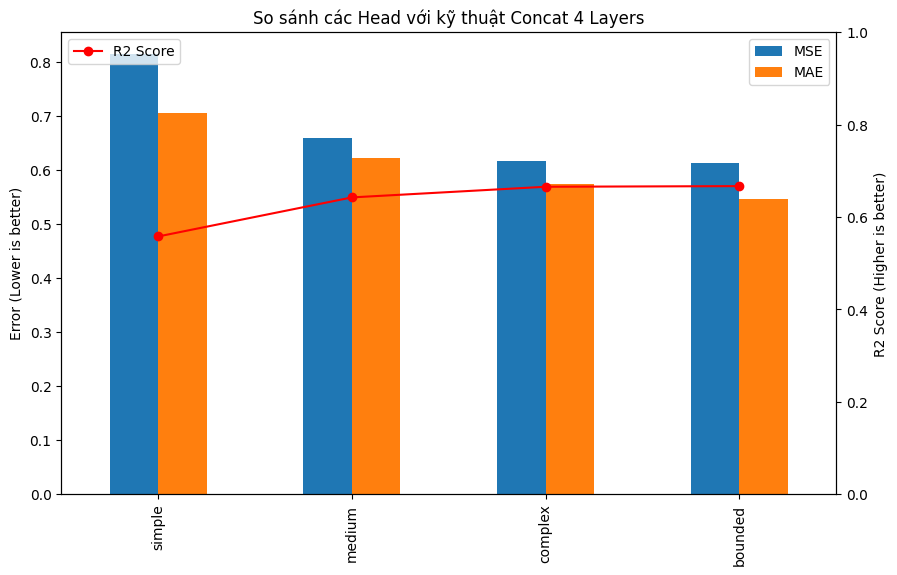

In [ ]:
# --- CONFIG CẬP NHẬT ---
head_types = ['simple', 'medium', 'complex', 'bounded']
results = {}
EPOCHS = 20  
PATIENCE = 4 # Tăng nhẹ patience để model có thời gian làm quen với vector 3072 chiều
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
historiesPath = 'finetune_histories_smote_concat4_HubLoss.json'
modelSacvePath = '_best_model_smote_concat4_HubLoss.pt'
print(f"{'='*10} BẮT ĐẦU THỬ NGHIỆM: SMOTE + CONCAT 4 LAYERS {'='*10}")
finetune_head_histories = {}

for head in head_types:
    print(f"\n Đang train Head type: {head.upper()}...")
    
    model = BERTRegressor_head(head_type=head).to(device)
    
    # --- THAY ĐỔI 1: SỬ DỤNG HUBER LOSS ---
    # delta=1.0 là mặc định, giúp cân bằng giữa MSE và MAE
    criterion = nn.HuberLoss(delta=1.0) 
    
    # --- THAY ĐỔI 2: ĐIỀU CHỈNH LEARNING RATE ---
    # Giảm nhẹ LR xuống 3e-4 để hội tụ ổn định hơn với input 3072 chiều
    optimizer = torch.optim.Adam(model.regressor.parameters(), lr=0.0003)
    
    save_path = f'{head}{modelSacvePath}'
    early_stopping = EarlyStopping(patience=PATIENCE, verbose=True, path=save_path)
    
    train_losses, val_losses = [], []

    for epoch in range(EPOCHS):
        # --- TRAIN VỚI SMOTE VECTORS ---
        model.train()
        batch_losses = []
        for d in train_loader: 
            # smote_vectors lúc này phải là (Batch, 3072)
            smote_vectors = d["input_ids"].to(device) 
            targets = d["targets"].to(device)

            outputs = model(smote_inputs=smote_vectors) 
            loss = criterion(outputs.squeeze(), targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        
        avg_train_loss = np.mean(batch_losses)
        train_losses.append(avg_train_loss)

        model.eval()
        val_batch_losses = []
        with torch.no_grad():
            for d in val_loader: 
                input_ids = d["input_ids"].to(device)
                attention_mask = d["attention_mask"].to(device)
                targets = d["targets"].to(device)
                
                # Model tự xử lý concat 4 layers bên trong forward
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(outputs.squeeze(), targets)
                val_batch_losses.append(loss.item())
        
        avg_val_loss = np.mean(val_batch_losses)
        val_losses.append(avg_val_loss)

        print(f"  Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            print("  ==> Early Stopping!")
            break
            
    # Load model tốt nhất và đánh giá
    model.load_state_dict(torch.load(save_path))
    mse, mae, r2, _, _ = evaluate_model(model, test_loader, device)
    
    results[head] = {
        'MSE': mse, 
        'MAE': mae, 
        'R2': r2, # Thêm R2 để so sánh độ chính xác tổng thể
        'Best_Epoch': epoch - PATIENCE + 1
    }
    print(f"   Kết quả cuối {head}: MSE={mse:.4f}, R2={r2:.4f}")
    
    finetune_head_histories[head] = {'train_loss': train_losses, 'val_loss': val_losses}

# Lưu lịch sử
with open(historiesPath, 'w') as f:
    json.dump(finetune_head_histories, f)

# --- TỔNG KẾT ---
print(f"\n{'='*10} BẢNG SO SÁNH CUỐI CÙNG {'='*10}")
results_df = pd.DataFrame(results).T
print(results_df)

# Vẽ biểu đồ so sánh MSE và R2
fig, ax1 = plt.subplots(figsize=(10, 6))

results_df[['MSE', 'MAE']].plot(kind='bar', ax=ax1)
ax1.set_ylabel('Error (Lower is better)')
ax1.set_title('So sánh các Head với kỹ thuật Concat 4 Layers')

# Vẽ R2 trên trục phụ vì thang đo khác nhau (0 -> 1)
ax2 = ax1.twinx()
results_df['R2'].plot(kind='line', marker='o', color='red', ax=ax2, label='R2 Score')
ax2.set_ylabel('R2 Score (Higher is better)')
ax2.set_ylim(0, 1)
ax2.legend(loc='upper left')

plt.show()

Đã load lịch sử huấn luyện thành công!
========== ĐÁNH GIÁ VÀ VẼ BIỂU ĐỒ CHI TIẾT ==========
Đang đánh giá model: SIMPLE...
Đang đánh giá model: MEDIUM...
Đang đánh giá model: COMPLEX...
Đang đánh giá model: BOUNDED...


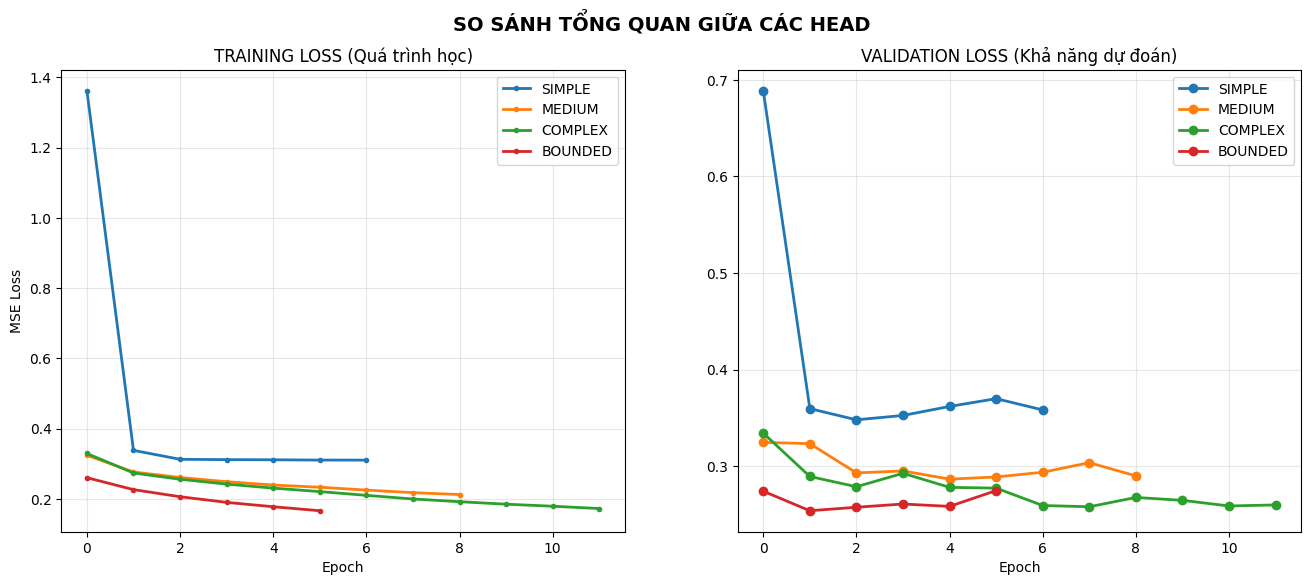


BẢNG XẾP HẠNG KẾT QUẢ (SMOTE TRAINING)
      Head       MSE       MAE        R2  Accuracy
3  BOUNDED  0.613716  0.546063  0.666748  0.577536
2  COMPLEX  0.616257  0.574192  0.665368  0.558219
1   MEDIUM  0.658718  0.622974  0.642311  0.503700
0   SIMPLE  0.814417  0.705020  0.557766  0.443565


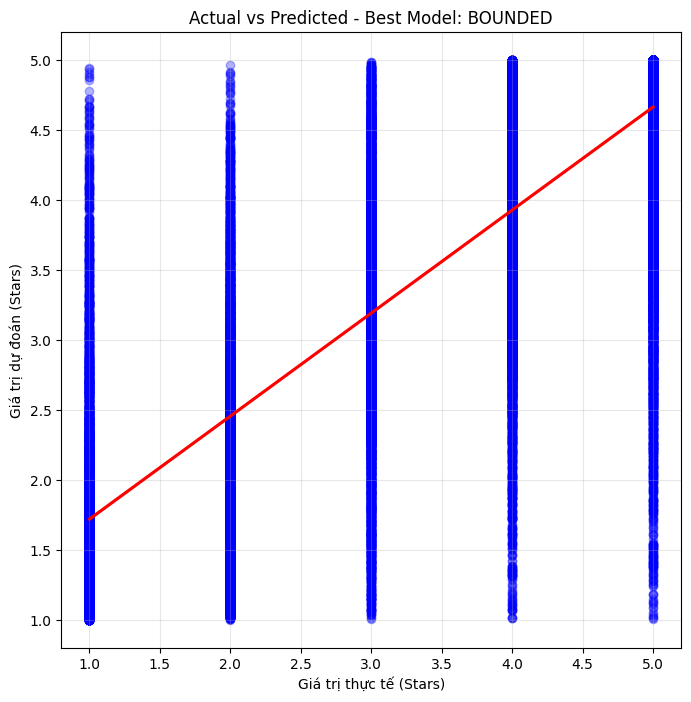

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pandas as pd
import torch
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
head_types = ['simple', 'medium', 'complex', 'bounded'] # Đảm bảo list này giống lúc train

# 1. LOAD LỊCH SỬ TRAINING
try:
    with open(historiesPath, 'r') as f:
        histories = json.load(f)
    print("Đã load lịch sử huấn luyện thành công!")
except FileNotFoundError:
    print("CHƯA CÓ FILE LỊCH SỬ! Vui lòng chạy Cell Training trước.")
    histories = {} # Tạo dict rỗng để tránh lỗi vẽ biểu đồ sau này

final_results = []
all_preds = {}

# 2. ĐÁNH GIÁ MÔ HÌNH 
print(f"{'='*10} ĐÁNH GIÁ VÀ VẼ BIỂU ĐỒ CHI TIẾT {'='*10}")

for head in head_types:
    try:
        print(f"Đang đánh giá model: {head.upper()}...")
        
        model = BERTRegressor_head(head_type=head).to(device)
        
        # Load weight đã train
        model_path = f'{head}{modelSacvePath}' 
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()
        
        preds, actuals = [], []
        with torch.no_grad():
            for d in test_loader:
                input_ids = d['input_ids'].to(device)
                mask = d['attention_mask'].to(device)
                targets = d['targets'].to(device)
                
                outputs = model(input_ids=input_ids, attention_mask=mask)
                
                # Xử lý output
                p = outputs.squeeze().tolist()
                if isinstance(p, float):
                    preds.append(p)
                else:
                    preds.extend(p)
                actuals.extend(targets.tolist())
        
        mse = mean_squared_error(actuals, preds)
        mae = mean_absolute_error(actuals, preds)
        r2 = r2_score(actuals, preds)
        # Tính accuracy (làm tròn số sao dự đoán để so sánh)
        acc = np.mean(np.round(preds) == np.array(actuals))
        
        final_results.append({'Head': head.upper(), 'MSE': mse, 'MAE': mae, 'R2': r2, 'Accuracy': acc})
        all_preds[head] = {'actual': actuals, 'pred': preds}
        
    except Exception as e:
        print(f"Lỗi khi đánh giá model {head}: {e}")
        print("Gợi ý: Kiểm tra lại tên Class Model hoặc đường dẫn file .pt")

# 3. VẼ BIỂU ĐỒ LOSS
plt.rcParams.update({'font.size': 10})

if histories: # Chỉ vẽ nếu có lịch sử
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Vẽ Train Loss
    for head in head_types:
        if head in histories and len(histories[head]['train_loss']) > 0:
            axes[0].plot(histories[head]['train_loss'], label=f'{head.upper()}', marker='.', linewidth=2)
    axes[0].set_title('TRAINING LOSS (Quá trình học)')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('MSE Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Vẽ Val Loss
    for head in head_types:
        if head in histories and len(histories[head]['val_loss']) > 0:
            axes[1].plot(histories[head]['val_loss'], label=f'{head.upper()}', marker='o', linewidth=2)
    axes[1].set_title('VALIDATION LOSS (Khả năng dự đoán)')
    axes[1].set_xlabel('Epoch')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.suptitle("SO SÁNH TỔNG QUAN GIỮA CÁC HEAD", fontsize=14, fontweight='bold')
    plt.show()

# 4. HIỂN THỊ BẢNG KẾT QUẢ
if final_results:
    df_res = pd.DataFrame(final_results).sort_values(by='MSE')
    print("\n" + "="*40)
    print("BẢNG XẾP HẠNG KẾT QUẢ (SMOTE TRAINING)")
    print("="*40)
    print(df_res)
    
    # 5. VẼ BIỂU ĐỒ ACTUAL VS PREDICTED (Cho model tốt nhất)
    # Tìm model có MSE thấp nhất
    best_head_name = df_res.iloc[0]['Head'].lower()
    
    if best_head_name in all_preds:
        actuals = all_preds[best_head_name]['actual']
        preds = all_preds[best_head_name]['pred']

        plt.figure(figsize=(8, 8))
        sns.regplot(x=actuals, y=preds, scatter_kws={'alpha':0.3, 'color':'blue'}, line_kws={'color':'red'})
        plt.xlabel('Giá trị thực tế (Stars)')
        plt.ylabel('Giá trị dự đoán (Stars)')
        plt.title(f'Actual vs Predicted - Best Model: {best_head_name.upper()}')
        plt.grid(True, alpha=0.3)
        plt.show()
    else:
        print(f"Không tìm thấy dữ liệu dự đoán cho {best_head_name}")
else:
    print("Không có kết quả nào được ghi nhận. Vui lòng kiểm tra lỗi ở trên.")

# Thử nghiệm với MSE Loss Function

========== BẮT ĐẦU THỬ NGHIỆM: SMOTE + CONCAT 4 LAYERS ==========

 Đang train Head type: SIMPLE...
  Epoch 1/20 | Train Loss: 4.5766 | Val Loss: 1.9828
Loss giam. Luu model...
  Epoch 2/20 | Train Loss: 0.8166 | Val Loss: 0.8557
Loss giam. Luu model...
  Epoch 3/20 | Train Loss: 0.7013 | Val Loss: 0.7985
Loss giam. Luu model...
  Epoch 4/20 | Train Loss: 0.6986 | Val Loss: 0.8655
EarlyStopping: 1/4
  Epoch 5/20 | Train Loss: 0.6997 | Val Loss: 0.8259
EarlyStopping: 2/4
  Epoch 6/20 | Train Loss: 0.7007 | Val Loss: 0.8395
EarlyStopping: 3/4
  Epoch 7/20 | Train Loss: 0.6966 | Val Loss: 0.8466
EarlyStopping: 4/4
  ==> Early Stopping!
   Kết quả cuối simple: MSE=0.8115, R2=0.5594

 Đang train Head type: MEDIUM...
  Epoch 1/20 | Train Loss: 0.7474 | Val Loss: 0.7326
Loss giam. Luu model...
  Epoch 2/20 | Train Loss: 0.6219 | Val Loss: 0.7124
Loss giam. Luu model...
  Epoch 3/20 | Train Loss: 0.5876 | Val Loss: 0.7018
Loss giam. Luu model...
  Epoch 4/20 | Train Loss: 0.5556 | Val Loss: 0.

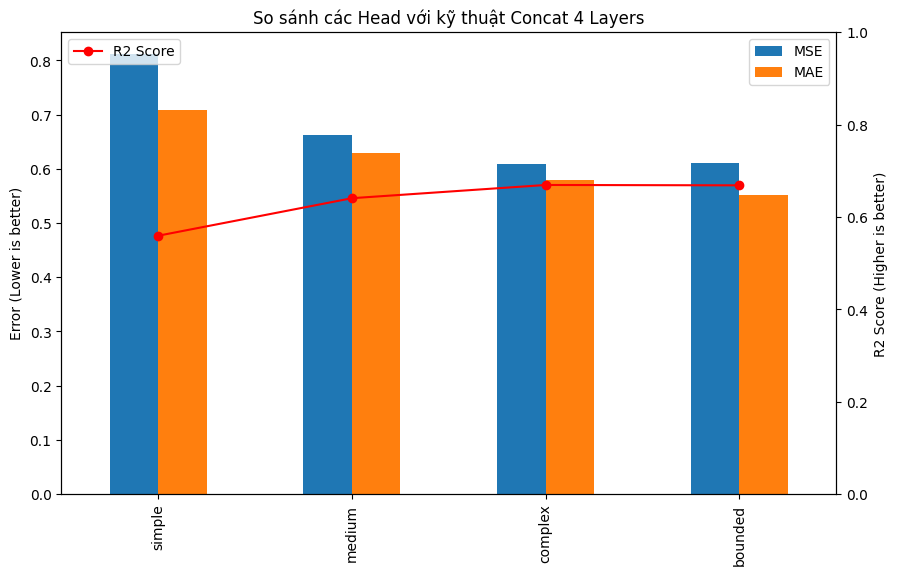

In [ ]:
# --- CONFIG CẬP NHẬT ---
head_types = ['simple', 'medium', 'complex', 'bounded']
results = {}
EPOCHS = 20  
PATIENCE = 4 # Tăng nhẹ patience để model có thời gian làm quen với vector 3072 chiều
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
historiesPath = 'finetune_histories_smote_concat4_mse.json'
modelSacvePath = '_best_model_smote_concat4_mse.pt'
print(f"{'='*10} BẮT ĐẦU THỬ NGHIỆM: SMOTE + CONCAT 4 LAYERS {'='*10}")
finetune_head_histories = {}

for head in head_types:
    print(f"\n Đang train Head type: {head.upper()}...")
    
    model = BERTRegressor_head(head_type=head).to(device)
    
    # --- THAY ĐỔI 1: SỬ DỤNG HUBER LOSS ---
    # delta=1.0 là mặc định, giúp cân bằng giữa MSE và MAE
    criterion = nn.MSELoss()
    
    # Giảm nhẹ LR xuống 3e-4 để hội tụ ổn định hơn với input 3072 chiều
    optimizer = torch.optim.Adam(model.regressor.parameters(), lr=0.0003)
    
    save_path = f'{head}{modelSacvePath}'
    early_stopping = EarlyStopping(patience=PATIENCE, verbose=True, path=save_path)
    
    train_losses, val_losses = [], []

    for epoch in range(EPOCHS):
        # --- TRAIN VỚI SMOTE VECTORS ---
        model.train()
        batch_losses = []
        for d in train_loader: 
            # smote_vectors lúc này phải là (Batch, 3072)
            smote_vectors = d["input_ids"].to(device) 
            targets = d["targets"].to(device)

            outputs = model(smote_inputs=smote_vectors) 
            loss = criterion(outputs.squeeze(), targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        
        avg_train_loss = np.mean(batch_losses)
        train_losses.append(avg_train_loss)

        # --- VALIDATION VỚI TEXT GỐC ---
        model.eval()
        val_batch_losses = []
        with torch.no_grad():
            for d in val_loader: 
                input_ids = d["input_ids"].to(device)
                attention_mask = d["attention_mask"].to(device)
                targets = d["targets"].to(device)
                
                # Model tự xử lý concat 4 layers bên trong forward
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(outputs.squeeze(), targets)
                val_batch_losses.append(loss.item())
        
        avg_val_loss = np.mean(val_batch_losses)
        val_losses.append(avg_val_loss)

        print(f"  Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            print("  ==> Early Stopping!")
            break
            
    # Load model tốt nhất và đánh giá
    model.load_state_dict(torch.load(save_path))
    
    # Nhận 5 giá trị trả về từ hàm evaluate_model đã sửa ở bước trước
    mse, mae, r2, _, _ = evaluate_model(model, test_loader, device)
    
    results[head] = {
        'MSE': mse, 
        'MAE': mae, 
        'R2': r2, # Thêm R2 để so sánh độ chính xác tổng thể
        'Best_Epoch': epoch - PATIENCE + 1
    }
    print(f"   Kết quả cuối {head}: MSE={mse:.4f}, R2={r2:.4f}")
    
    finetune_head_histories[head] = {'train_loss': train_losses, 'val_loss': val_losses}

# Lưu lịch sử
with open(historiesPath, 'w') as f:
    json.dump(finetune_head_histories, f)

# --- TỔNG KẾT ---
print(f"\n{'='*10} BẢNG SO SÁNH CUỐI CÙNG {'='*10}")
results_df = pd.DataFrame(results).T
print(results_df)

# Vẽ biểu đồ so sánh MSE và R2
fig, ax1 = plt.subplots(figsize=(10, 6))

results_df[['MSE', 'MAE']].plot(kind='bar', ax=ax1)
ax1.set_ylabel('Error (Lower is better)')
ax1.set_title('So sánh các Head với kỹ thuật Concat 4 Layers')

# Vẽ R2 trên trục phụ vì thang đo khác nhau (0 -> 1)
ax2 = ax1.twinx()
results_df['R2'].plot(kind='line', marker='o', color='red', ax=ax2, label='R2 Score')
ax2.set_ylabel('R2 Score (Higher is better)')
ax2.set_ylim(0, 1)
ax2.legend(loc='upper left')

plt.show()

Đã load lịch sử huấn luyện thành công!
========== ĐÁNH GIÁ VÀ VẼ BIỂU ĐỒ CHI TIẾT ==========
Đang đánh giá model: SIMPLE...
Đang đánh giá model: MEDIUM...
Đang đánh giá model: COMPLEX...
Đang đánh giá model: BOUNDED...


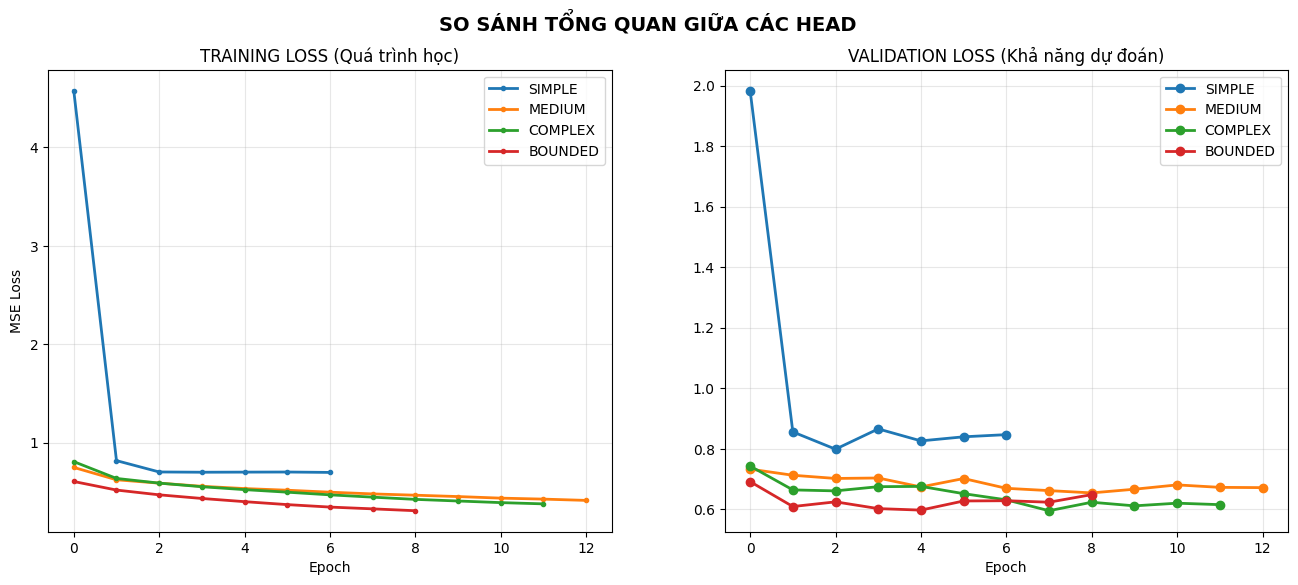


BẢNG XẾP HẠNG KẾT QUẢ (SMOTE TRAINING)
      Head       MSE       MAE        R2  Accuracy
2  COMPLEX  0.609164  0.579646  0.669219  0.550352
3  BOUNDED  0.610591  0.550934  0.668445  0.573302
1   MEDIUM  0.661888  0.628728  0.640590  0.495167
0   SIMPLE  0.811471  0.709110  0.559365  0.433581


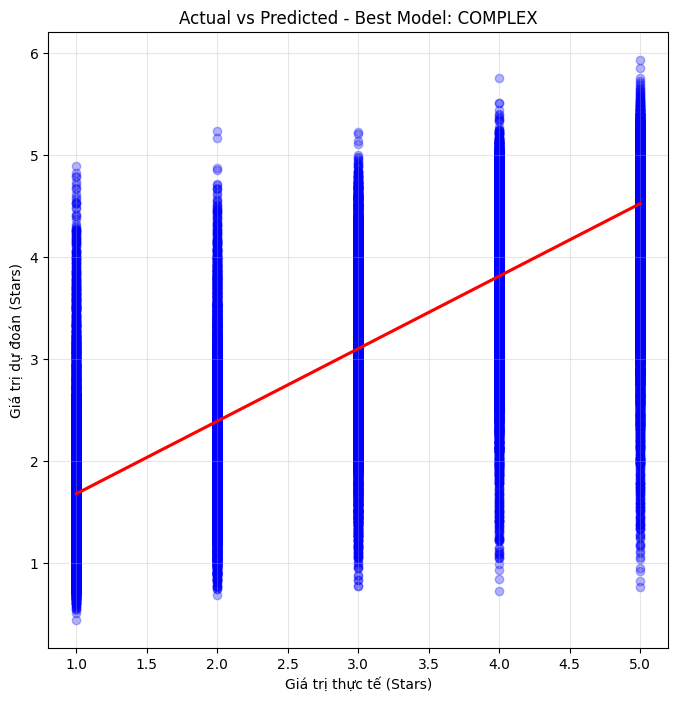

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pandas as pd
import torch
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
historiesPath = 'finetune_histories_smote_concat4_mse.json'
modelSacvePath = '_best_model_smote_concat4_mse.pt'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
head_types = ['simple', 'medium', 'complex', 'bounded'] # Đảm bảo list này giống lúc train

# 1. LOAD LỊCH SỬ TRAINING
try:
    with open(historiesPath, 'r') as f:
        histories = json.load(f)
    print("Đã load lịch sử huấn luyện thành công!")
except FileNotFoundError:
    print("CHƯA CÓ FILE LỊCH SỬ! Vui lòng chạy Cell Training trước.")
    histories = {} # Tạo dict rỗng để tránh lỗi vẽ biểu đồ sau này

final_results = []
all_preds = {}

# 2. ĐÁNH GIÁ MÔ HÌNH 
print(f"{'='*10} ĐÁNH GIÁ VÀ VẼ BIỂU ĐỒ CHI TIẾT {'='*10}")

for head in head_types:
    try:
        print(f"Đang đánh giá model: {head.upper()}...")

        model = BERTRegressor_head(head_type=head).to(device)

        
        # Load weight đã train
        model_path = f'{head}{modelSacvePath}' 
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()
        
        preds, actuals = [], []
        with torch.no_grad():
            for d in test_loader:
                input_ids = d['input_ids'].to(device)
                mask = d['attention_mask'].to(device)
                targets = d['targets'].to(device)
                
                # Gọi model (Test data là dữ liệu thật nên có input_ids và mask)
                outputs = model(input_ids=input_ids, attention_mask=mask)
                
                # Xử lý output
                p = outputs.squeeze().tolist()
                if isinstance(p, float):
                    preds.append(p)
                else:
                    preds.extend(p)
                actuals.extend(targets.tolist())
        
        # --- TÍNH TOÁN METRICS (Phần này bị thiếu ở code cũ) ---
        mse = mean_squared_error(actuals, preds)
        mae = mean_absolute_error(actuals, preds)
        r2 = r2_score(actuals, preds)
        # Tính accuracy (làm tròn số sao dự đoán để so sánh)
        acc = np.mean(np.round(preds) == np.array(actuals))
        
        final_results.append({'Head': head.upper(), 'MSE': mse, 'MAE': mae, 'R2': r2, 'Accuracy': acc})
        all_preds[head] = {'actual': actuals, 'pred': preds}
        
    except Exception as e:
        # ĐÂY LÀ PHẦN SỬA LỖI: In ra lỗi cụ thể nếu có
        print(f"Lỗi khi đánh giá model {head}: {e}")
        print("Gợi ý: Kiểm tra lại tên Class Model hoặc đường dẫn file .pt")

# 3. VẼ BIỂU ĐỒ LOSS
plt.rcParams.update({'font.size': 10})

if histories: # Chỉ vẽ nếu có lịch sử
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Vẽ Train Loss
    for head in head_types:
        if head in histories and len(histories[head]['train_loss']) > 0:
            axes[0].plot(histories[head]['train_loss'], label=f'{head.upper()}', marker='.', linewidth=2)
    axes[0].set_title('TRAINING LOSS (Quá trình học)')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('MSE Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Vẽ Val Loss
    for head in head_types:
        if head in histories and len(histories[head]['val_loss']) > 0:
            axes[1].plot(histories[head]['val_loss'], label=f'{head.upper()}', marker='o', linewidth=2)
    axes[1].set_title('VALIDATION LOSS (Khả năng dự đoán)')
    axes[1].set_xlabel('Epoch')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.suptitle("SO SÁNH TỔNG QUAN GIỮA CÁC HEAD", fontsize=14, fontweight='bold')
    plt.show()

# 4. HIỂN THỊ BẢNG KẾT QUẢ
if final_results:
    df_res = pd.DataFrame(final_results).sort_values(by='MSE')
    print("\n" + "="*40)
    print("BẢNG XẾP HẠNG KẾT QUẢ (SMOTE TRAINING)")
    print("="*40)
    print(df_res)
    
    # 5. VẼ BIỂU ĐỒ ACTUAL VS PREDICTED (Cho model tốt nhất)
    # Tìm model có MSE thấp nhất
    best_head_name = df_res.iloc[0]['Head'].lower() 
    
    if best_head_name in all_preds:
        actuals = all_preds[best_head_name]['actual']
        preds = all_preds[best_head_name]['pred']

        plt.figure(figsize=(8, 8))
        sns.regplot(x=actuals, y=preds, scatter_kws={'alpha':0.3, 'color':'blue'}, line_kws={'color':'red'})
        plt.xlabel('Giá trị thực tế (Stars)')
        plt.ylabel('Giá trị dự đoán (Stars)')
        plt.title(f'Actual vs Predicted - Best Model: {best_head_name.upper()}')
        plt.grid(True, alpha=0.3)
        plt.show()
    else:
        print(f"Không tìm thấy dữ liệu dự đoán cho {best_head_name}")
else:
    print("Không có kết quả nào được ghi nhận. Vui lòng kiểm tra lỗi ở trên.")